# Make It Talk

### Make the given face image talk, with the given speech text.

Original Author: [Yang Zhou](https://github.com/yzhou359)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/yzhou359/MakeItTalk

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/MakeItTalk.ipynb)

In [ ]:
#@title Setup

!git clone https://github.com/yzhou359/MakeItTalk
%cd MakeItTalk/

!pip install -r requirements.txt
!pip install tensorboardX
!pip install git+https://github.com/coqui-ai/TTS
!pip install -U numpy

!mkdir examples/dump
!mkdir examples/ckpt

CHECKPOINTS = {
    'ckpt_autovc': '1ZiwPp_h62LtjU0DwpelLUoodKPR85K7x',
    'ckpt_content_branch': '1r3bfEvTVl6pCNw5xwUhEglwDHjWtAqQp',
    'ckpt_speaker_branch': '1rV0jkyDqPW-aDJcj7xSO6Zt1zSXqn1mu',
    'ckpt_116_i2i_comb': '1i2LJXKp-yWKIEEgJ7C6cE3_2NirfY_0a',
}

for name, fid in CHECKPOINTS.items():
  !wget \
    "https://docs.google.com/uc?export=download&confirm=t&id={fid}" \
    -O examples/ckpt/{name}.pth

!wget \
  "https://docs.google.com/uc?export=download&confirm=t&id=18-0CYl5E6ungS3H4rRSHjfYvvm-WwjTI" \
  -O examples/dump/emb.pickle



Dropdown(index=17, options=('angelina', 'anne', 'anne2', 'audrey', 'aya', 'captain', 'captain2', 'cesi', 'chri…

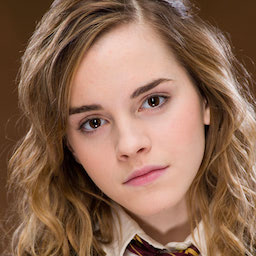

In [ ]:
#@title Upload Image or Choose One

import os
import glob
import ipywidgets as widgets
from google.colab import files
from IPython.display import display, clear_output
from PIL import Image


#@markdown Click to upload your own face image, or choose later after running this cell.
upload_your_own_image = False #@param {type:"boolean"}



def on_change(change):
  if change['type'] == 'change' and change['name'] == 'value':
    clear_output()
    display(default_head_name)
    f_name = f'examples/{default_head_name.value}.jpg'
    display(Image.open(f_name))
    os.environ['FILE_NAME'] = f_name


if upload_your_own_image:
  ff = files.upload()
  f_name = list(ff.keys())[0]
  display(f_name)
  os.environ['FILE_NAME'] = f_name
else:
  img_list = glob.glob1('examples', '*.jpg')
  img_list.sort()
  img_list = [item.split('.')[0] for item in img_list]
  default_head_name = widgets.Dropdown(options=img_list, value='hermione')
  default_head_name.observe(on_change)
  display(default_head_name)
  f_name = f'examples/{default_head_name.value}.jpg'
  display(Image.open(f_name))
  os.environ['FILE_NAME'] = f_name



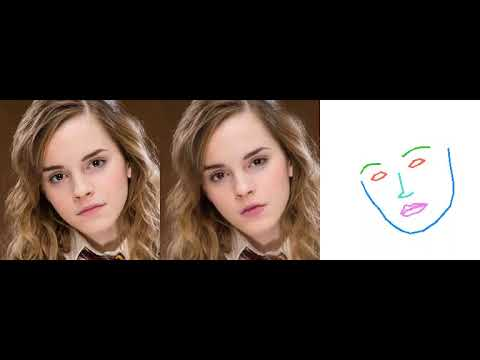

In [5]:
#@title Run

import sys
sys.path.append("thirdparty/AdaptiveWingLoss")
import argparse
from argparse import Namespace
import pickle
import shutil
import time
from IPython.display import HTML
from base64 import b64encode

import cv2
import torch
import face_alignment
import numpy as np
from scipy.signal import savgol_filter
from thirdparty.resemblyer_util.speaker_emb import get_spk_emb

import util.utils as util
from src.approaches.train_audio2landmark import Audio2landmark_model
from src.approaches.train_image_translation import Image_translation_block
from src.autovc.AutoVC_mel_Convertor_retrain_version import AutoVC_mel_Convertor


#@markdown Sentence to apply. The speeach will be generated automatically.
text = "Where there is a will, there is a way." #@param {type:"string"}

!tts \
  --use_cuda True \
  --text "{text}" \
  --model_name "tts_models/en/ljspeech/tacotron2-DCA" \
  --vocoder_name "vocoder_models/en/ljspeech/multiband-melgan" \
  --out_path ./out.wav


#@markdown ## [Optional Below]
#@markdown Amplify the lip motion in horizontal direction
AMP_LIP_SHAPE_X = 2.5 #@param {type:"slider", min:0.5, max:5.0, step:0.1}

#@markdown Amplify the lip motion in vertical direction
AMP_LIP_SHAPE_Y = 2.5 #@param {type:"slider", min:0.5, max:5.0, step:0.1}

#@markdown Amplify the head pose motion (usually smaller than 1.0, put it to 0. for a static head pose)
AMP_HEAD_POSE_MOTION = 0.5 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

#@markdown Add naive eye blink
ADD_NAIVE_EYE = True  #@param ["False", "True"] {type:"raw"}

#@markdown If your image has an opened mouth, put this as True, else False
CLOSE_INPUT_FACE_MOUTH = False  #@param ["False", "True"] {type:"raw"}          


#@markdown # Landmark Adjustment

#@markdown Adjust upper lip thickness (postive value means thicker)
UPPER_LIP_ADJUST = 0 #@param {type:"slider", min:-3.0, max:3.0, step:1.0}

#@markdown Adjust lower lip thickness (postive value means thicker)
LOWER_LIP_ADJUST = 0 #@param {type:"slider", min:-3.0, max:3.0, step:1.0}

#@markdown Adjust static lip width (in multipication)
LIP_WIDTH_ADJUST = 1.0 #@param {type:"slider", min:0.8, max:1.2, step:0.01}


opt_parser = Namespace(
  jpg=os.environ['FILE_NAME'],
  close_input_face_mouth=CLOSE_INPUT_FACE_MOUTH,
  amp_lip_x=AMP_LIP_SHAPE_X,
  amp_lip_y=AMP_LIP_SHAPE_Y,
  amp_pos=AMP_HEAD_POSE_MOTION,
  output_folder='examples',
  load_AUTOVC_name='examples/ckpt/ckpt_autovc.pth',
  load_a2l_G_name='examples/ckpt/ckpt_speaker_branch.pth',
  load_a2l_C_name='examples/ckpt/ckpt_content_branch.pth',
  load_G_name='examples/ckpt/ckpt_116_i2i_comb.pth',
  reuse_train_emb_list=[],
  add_audio_in=False,
  comb_fan_awing=False,
  test_end2end=True,
  dump_dir='',
  pos_dim=7,
  use_prior_net=True,
  transformer_d_model=32,
  transformer_N=2,
  transformer_heads=2,
  spk_emb_enc_size=16,
  init_content_encoder='',
  lr=1e-3,
  reg_lr=1e-6,
  write=False,
  segment_batch_size=1,
  emb_coef=3.0,
  lambda_laplacian_smooth_loss=1.0,
  use_11spk_only=False
)

img = cv2.imread(opt_parser.jpg)
predictor = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cpu', flip_input=True)
shapes = predictor.get_landmarks(img)
if (not shapes or len(shapes) != 1):
    print('Cannot detect face landmarks. Exit.')
    exit(-1)

shape_3d = shapes[0]
if(opt_parser.close_input_face_mouth):
    util.close_input_face_mouth(shape_3d)

shape_3d[48:, 0] = (shape_3d[48:, 0] - np.mean(shape_3d[48:, 0])) * LIP_WIDTH_ADJUST + np.mean(shape_3d[48:, 0]) # wider lips
shape_3d[49:54, 1] -= UPPER_LIP_ADJUST  # thinner upper lip
shape_3d[55:60, 1] += LOWER_LIP_ADJUST  # thinner lower lip
shape_3d[[37,38,43,44], 1] -=2.  # larger eyes
shape_3d[[40,41,46,47], 1] +=2.  # larger eyes
shape_3d, scale, shift = util.norm_input_face(shape_3d)

print("Loaded Image...", file=sys.stderr)

au_data = []
au_emb = []
# ains = glob.glob1('examples', '*.wav')
# ains = [item for item in ains if item is not 'tmp.wav']
# ains.sort()
!cp out.wav examples/out.wav
ains = ["out.wav"]
for ain in ains:
  !ffmpeg -y -loglevel error -i out.wav -ar 16000 examples/tmp.wav
  !cp examples/tmp.wav examples/ain

  # au embedding
  me, ae = get_spk_emb('examples/{}'.format(ain))
  au_emb.append(me.reshape(-1))

  print('Processing audio file', ain)
  c = AutoVC_mel_Convertor('examples')

  au_data_i = c.convert_single_wav_to_autovc_input(
    audio_filename=os.path.join('examples', ain),
    autovc_model_path=opt_parser.load_AUTOVC_name
  )
  au_data += au_data_i

if(os.path.isfile('examples/tmp.wav')):
  os.remove('examples/tmp.wav')

print("Loaded audio...", file=sys.stderr)

# landmark fake placeholder
fl_data = []
rot_tran, rot_quat, anchor_t_shape = [], [], []
for au, info in au_data:
  au_length = au.shape[0]
  fl = np.zeros(shape=(au_length, 68 * 3))
  fl_data.append((fl, info))
  rot_tran.append(np.zeros(shape=(au_length, 3, 4)))
  rot_quat.append(np.zeros(shape=(au_length, 4)))
  anchor_t_shape.append(np.zeros(shape=(au_length, 68 * 3)))

if(os.path.exists(os.path.join('examples', 'dump', 'random_val_fl.pickle'))):
  os.remove(os.path.join('examples', 'dump', 'random_val_fl.pickle'))
if(os.path.exists(os.path.join('examples', 'dump', 'random_val_fl_interp.pickle'))):
  os.remove(os.path.join('examples', 'dump', 'random_val_fl_interp.pickle'))
if(os.path.exists(os.path.join('examples', 'dump', 'random_val_au.pickle'))):
  os.remove(os.path.join('examples', 'dump', 'random_val_au.pickle'))
if (os.path.exists(os.path.join('examples', 'dump', 'random_val_gaze.pickle'))):
  os.remove(os.path.join('examples', 'dump', 'random_val_gaze.pickle'))

with open(os.path.join('examples', 'dump', 'random_val_fl.pickle'), 'wb') as fp:
  pickle.dump(fl_data, fp)
with open(os.path.join('examples', 'dump', 'random_val_au.pickle'), 'wb') as fp:
  pickle.dump(au_data, fp)
with open(os.path.join('examples', 'dump', 'random_val_gaze.pickle'), 'wb') as fp:
  gaze = {'rot_trans':rot_tran, 'rot_quat':rot_quat, 'anchor_t_shape':anchor_t_shape}
  pickle.dump(gaze, fp)

model = Audio2landmark_model(opt_parser, jpg_shape=shape_3d)
if(len(opt_parser.reuse_train_emb_list) == 0):
  model.test(au_emb=au_emb)
else:
  model.test(au_emb=None)

clear_output()
print("Audio->Landmark...", file=sys.stderr)

fls = glob.glob1('examples', 'pred_fls_*.txt')
fls.sort()

for i in range(0,len(fls)):
  fl = np.loadtxt(os.path.join('examples', fls[i])).reshape((-1, 68,3))
  fl[:, :, 0:2] = -fl[:, :, 0:2]
  fl[:, :, 0:2] = fl[:, :, 0:2] / scale - shift

  if (ADD_NAIVE_EYE):
    fl = util.add_naive_eye(fl)

  # additional smooth
  fl = fl.reshape((-1, 204))
  fl[:, :48*3] = savgol_filter(fl[:, :48*3], 15, 3, axis=0)
  fl[:, 48*3:] = savgol_filter(fl[:, 48*3:], 5, 3, axis=0)
  fl = fl.reshape((-1, 68, 3))

  # STEP 6: Imag2image translation
  model = Image_translation_block(opt_parser, single_test=True)
  with torch.no_grad():
    model.single_test(jpg=img, fls=fl, filename=fls[i], prefix=opt_parser.jpg.split('.')[0])
    print('finish image2image gen')
  os.remove(os.path.join('examples', fls[i]))

  print("{} / {}: Landmark->Face...".format(i+1, len(fls)), file=sys.stderr)


# Merge the video and audio
!ffmpeg \
  -loglevel error \
  -y \
  -i out.mp4 \
  -itsoffset 00:00:01 \
  -i examples/ain \
  -pix_fmt yuv420p \
  -strict \
  -2 \
  final.mp4


clear_output()
print("Done!", file=sys.stderr)

files.download('final.mp4')

mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(
  HTML(f"""
    <video width=600 controls>
      <source src="{data_url}" type="video/mp4">
    </video>
  """)
)
